# Comparison of all perturbations
Use extracted features to build per-cell representations and analyse similarity of perturbations with them
- plot UMAP
- calculate distance of perturbartions 

In [1]:
from campa.tl import Experiment
from campa.tl import FeatureExtractor
from campa.utils import init_logging
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import squidpy as sq
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

Reading config from /mnt/home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2.5h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (1h)'
    p[p == 'CX5461-120'] = 'CX5461 (2.5h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12.5h)'
    p[p == 'TSA-30'] = 'TSA (1h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2.5h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')
    print(adata.obs['perturbation_plot'].cat.categories)
    adata.uns['perturbation_plot_colors'] = ['#377eb8', '#984ea3', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#999999']  #https://gist.github.com/thriveth/8560036


In [3]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
os.makedirs(str(fig_dir), exist_ok=True)

In [4]:
from numba import jit, njit
#from scipy.spatial.distance import cityblock

@njit
def cityblock(a,b,w=None):
    if w is None:
        w = np.ones_like(a)
    return np.mean(np.abs(a-b)*w)

def calc_co_occ_knn(adata, cluster_pairs=None, key_added='co_occurrence'):
    """
    Calculate knn graph using co_occurrence scores.

    Args:
        adata: concatenated feature adata containing co_occurrence scores in adata.obsm
        cluster_pairs: list of cluster tuples that should be used to calculate neighborhood graph. 
            If none, all available cluster pairs are used

    adds 
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if cluster_pairs is None:
        cluster_pairs = [(c1, c2) for c1 in adata.uns['clusters'] for c2 in adata.uns['clusters']]
    co_occ_keys = [f'co_occurrence_{c1}_{c2}' for c1, c2 in cluster_pairs]

    # build combined co-occ matrix
    arr = np.concatenate([adata.obsm[k] for k in co_occ_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr

    # weights to use for l1 distance
    distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, metric_kwds={'w': np.tile(distances/np.mean(distances), len(cluster_pairs))}, key_added=key_added)

def calc_intensity_knn(adata, clusters=None, key_added='intensity'):
    """
    Calculate knn graph using mean cluster intensity.

    Args:
        adata: concatenated feature adata containing intensity scores in adata.obsm
        clusters: list of cluster names that should be used to calculate neighborhood graph.
            If none, all available cluster pairs are used.

    adds
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if clusters is None:
        clusters = adata.uns['clusters']
    intensity_keys = [f'intensity_{c}' for c in clusters]
    
    # build combined intensity matrix
    arr = np.concatenate([adata.layers[k] for k in intensity_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, key_added=key_added)

## Load data

In [5]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

# get combined adata
adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata)

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

Index(['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)',
       'TSA (1h)', 'Triptolide (2.5h)', 'unperturbed'],
      dtype='object')


In [6]:
# print perturbation_plot color map
d = {}
for i,p in enumerate(adata.obs['perturbation_plot'].cat.categories):
    d[p] = adata.uns['perturbation_plot_colors'][i]
d

{'AZD4573 (1h)': '#377eb8',
 'AZD4573 (2.5h)': '#984ea3',
 'CX5461 (2.5h)': '#ff7f00',
 'Meayamycin (12.5h)': '#4daf4a',
 'TSA (1h)': '#f781bf',
 'Triptolide (2.5h)': '#a65628',
 'unperturbed': '#999999'}

## Calculate knn based on intensity and co-occ scores

In [13]:
calc_co_occ_knn(adata, key_added='co_occurrence')
adata.obsm['X_co_occurrence_umap'] = sc.tl.umap(adata, min_dist=0.05, spread=2, neighbors_key='co_occurrence', copy=True).obsm['X_umap']

In [14]:
calc_intensity_knn(adata, key_added='intensity')
adata.obsm['X_intensity_umap'] = sc.tl.umap(adata, neighbors_key='intensity', copy=True).obsm['X_umap']

In [15]:
# mean intensity knn with X
sc.pp.neighbors(adata, metric=cityblock, key_added='mpp')
adata.obsm['X_mpp_umap'] = sc.tl.umap(adata, neighbors_key='mpp', copy=True).obsm['X_umap']

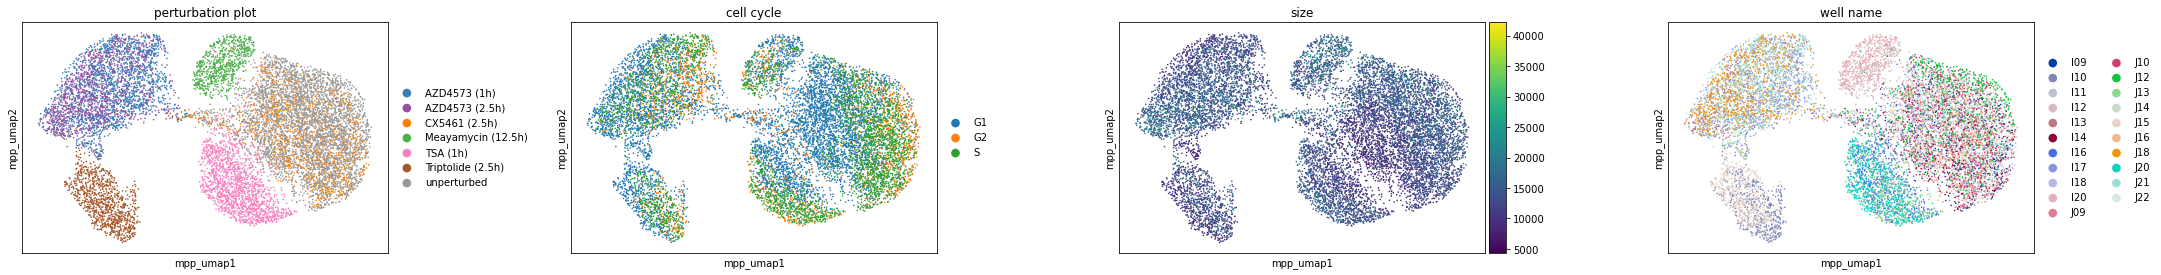

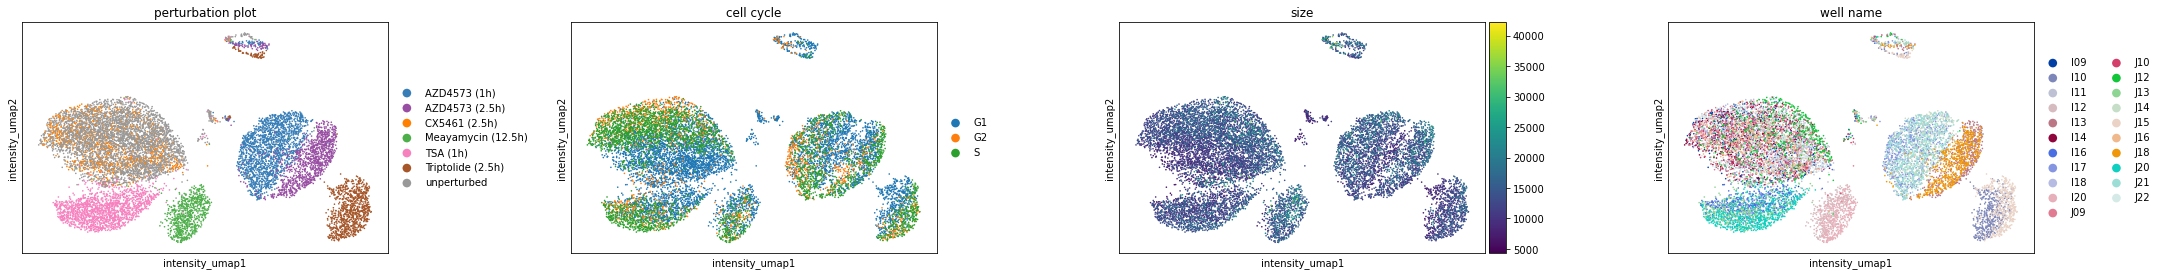

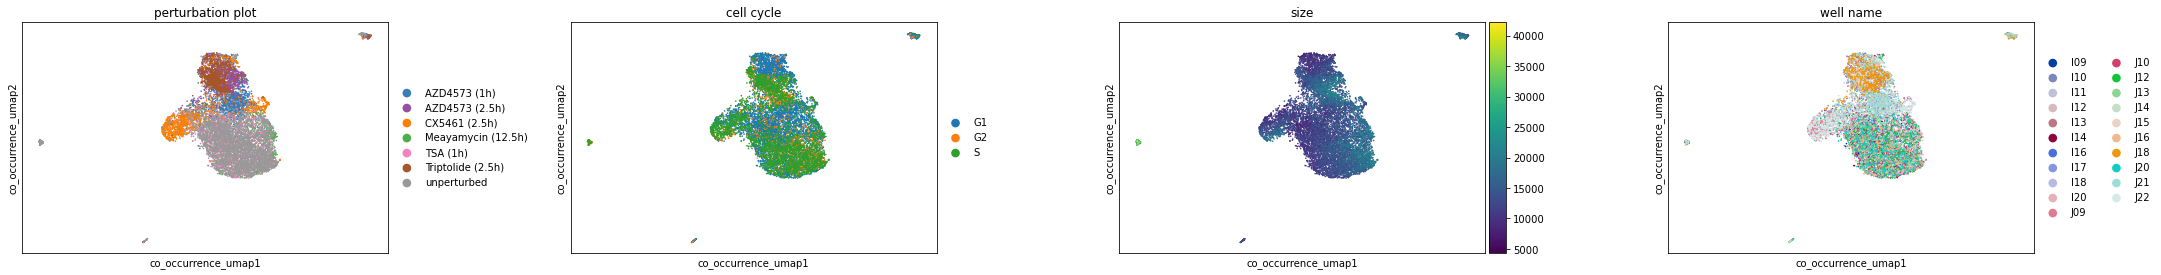

In [71]:
adata.obs['size'] = adata.obsm['size']['all']
sc.pl.scatter(adata, basis='mpp_umap', color=['perturbation_plot', 'cell_cycle', 'size', 'well_name'])
sc.pl.scatter(adata, basis='intensity_umap', color=['perturbation_plot', 'cell_cycle', 'size', 'well_name'])
sc.pl.scatter(adata, basis='co_occurrence_umap', color=['perturbation_plot', 'cell_cycle', 'size', 'well_name'])

In [73]:
# save adata - with fix for params, as pickling functions is not supported
adata.uns['co_occurrence']['params']['metric'] = 'manhattan'
adata.uns['intensity']['params']['metric'] = 'manhattan'
adata.uns['mpp']['params']['metric'] = 'manhattan'
adata.write(fig_dir/'cell_adata.h5ad')

### Remove outliers using co-occ umap coords
for more details about the outlier cells, see `fig4_suppl_UMAP_outliers.ipynb`

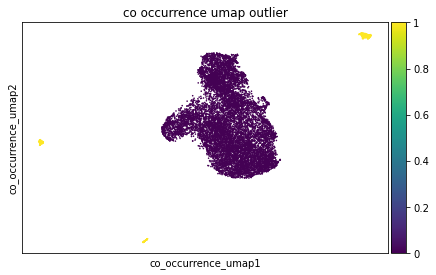

In [12]:
# threshold outliers 
outliers = ~((adata.obsm['X_co_occurrence_umap'][:,0] > 0) & (adata.obsm['X_co_occurrence_umap'][:,0] < 20))
adata.obs['co_occurrence_umap_outlier'] = outliers

sc.pl.scatter(adata, basis='co_occurrence_umap', color=['co_occurrence_umap_outlier'])

adata.write(fig_dir/'cell_adata.h5ad')

## Plot UMAPs

In [7]:
adata = ad.read(fig_dir/'cell_adata.h5ad')
# remove outliers according to co_occ umap
adata = adata[~adata.obs['co_occurrence_umap_outlier']]

In [21]:
def catplot(basis, color, axlabel, title=None, save=None):
    fig, ax = plt.subplots(1,1)
    sc.pl.scatter(adata, basis=basis, color=color, ax=ax, show=False)
    ax.set_ylabel(f'{axlabel}2')
    ax.set_xlabel(f'{axlabel}1')
    if title is not None:
        ax.set_title(title)
    if save is not None:
        plt.savefig(fig_dir/save, dpi=100, bbox_inches='tight')
    


### Main Figure: UMAPs

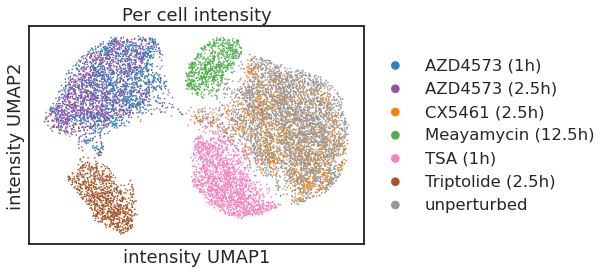

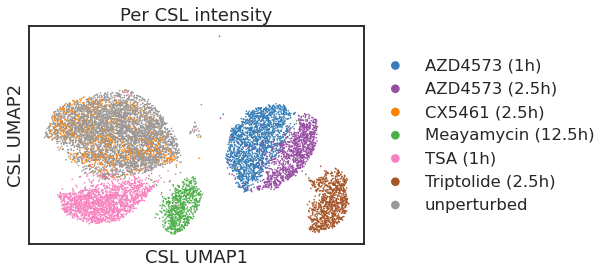

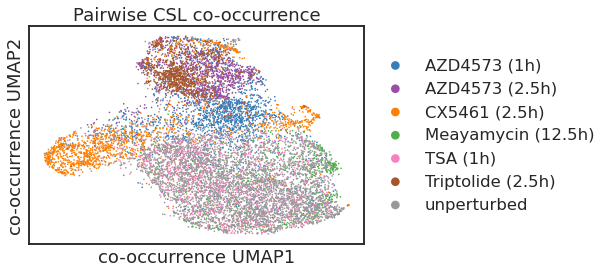

In [22]:
# final UMAP figure
sns.set_style('white')
sns.set_context('talk')

catplot('mpp_umap', 'perturbation_plot', 'intensity UMAP', save='intensity_umap.png', title='Per cell intensity')
catplot('intensity_umap', 'perturbation_plot', 'CSL UMAP', save='cluster_intensity_umap.png', title='Per CSL intensity')
catplot('co_occurrence_umap', 'perturbation_plot', 'co-occurrence UMAP', save='co_occ_umap.png', title='Pairwise CSL co-occurrence')


### Suppl Figure: Perturbation distribution on co-occ UMAP

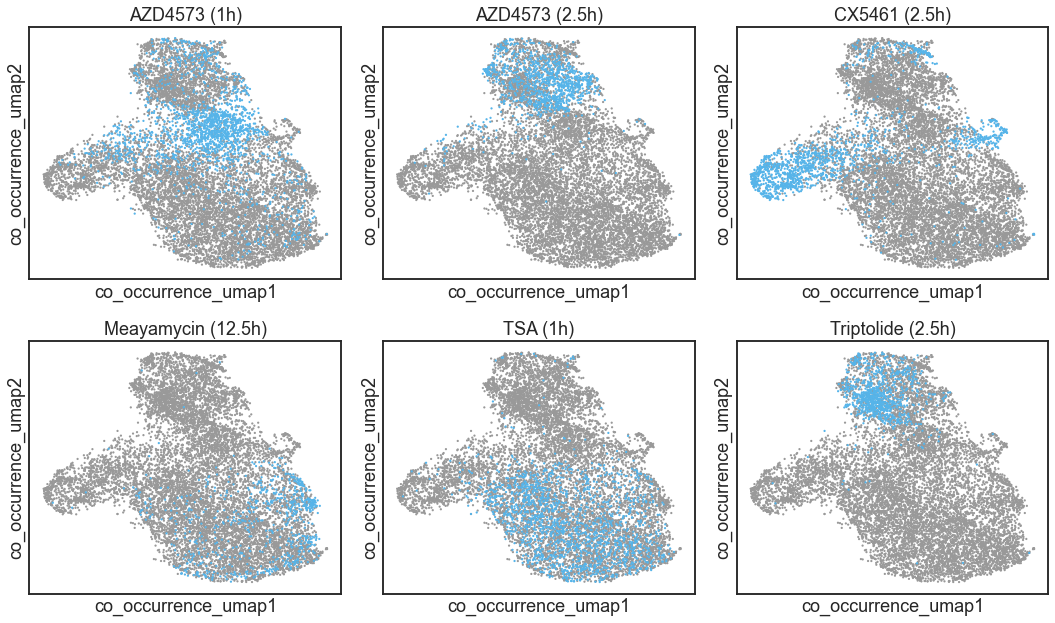

In [9]:
# maybe suppl figure
fig, axes = plt.subplots(2,3, figsize=(15,9))
i = 0
for p in adata.obs['perturbation_plot'].cat.categories:
    if p == 'unperturbed':
        continue
    ax = axes.flat[i]
    i += 1
    tmp = adata.copy()
    tmp.obs[p] = (tmp.obs['perturbation_plot'] == p).astype('category')
    tmp.uns[f'{p}_colors'] = ["#999999", "#56B4E9"]
    
    indices = set(range(tmp.shape[0]))
    p_indices = list(np.where(tmp.obs['perturbation_plot'] == p)[0])
    reordered_indices = list(indices.difference(p_indices)) + p_indices

    sc.pl.embedding(tmp[reordered_indices], color=p, basis='co_occurrence_umap', ax=ax, show=False, legend_loc='none', size=20)
plt.tight_layout()
plt.savefig(fig_dir/'co_occ_umap_suppl.png', dpi=100, bbox_inches='tight')

### Suppl figure: well-well effects per perturbation

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_74972/3919403011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.obs[p][~(tmp.obs['perturbation_plot'] == p)] = 'other'
/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_74972/3919403011.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.obs[p][~(tmp.obs['perturbation_plot'] == p)] = 'other'
/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_74972/3919403011.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

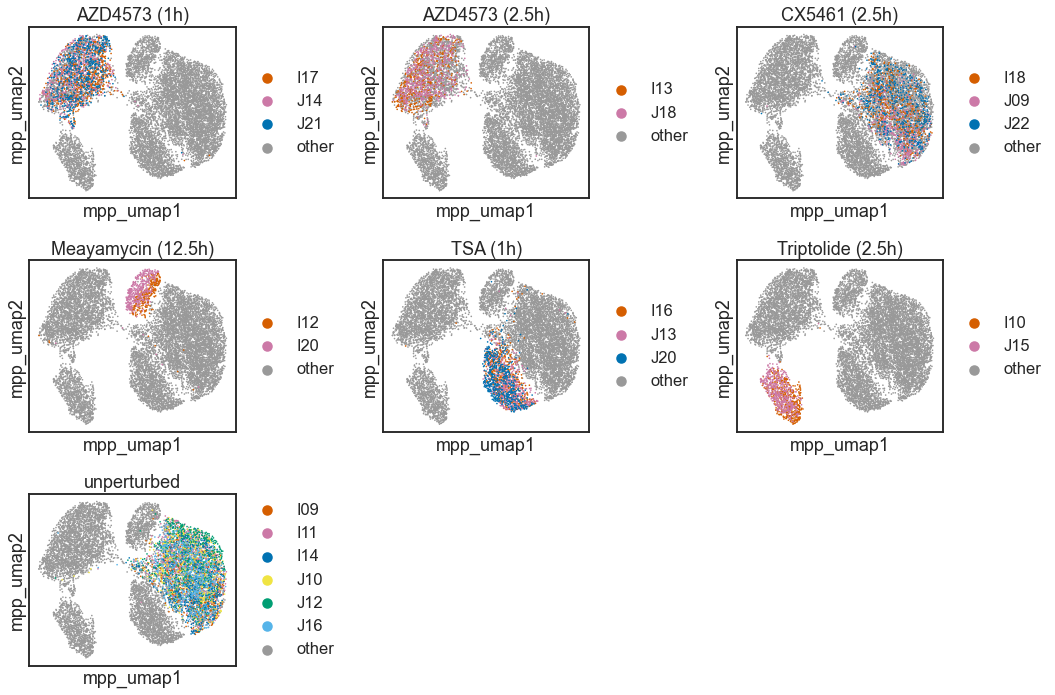

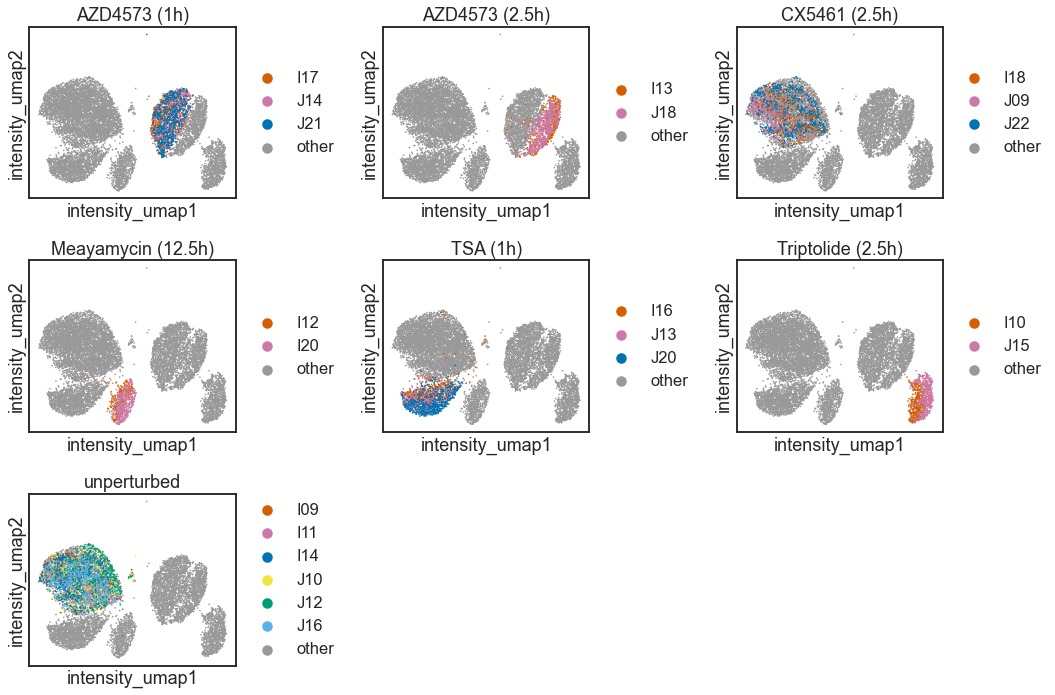

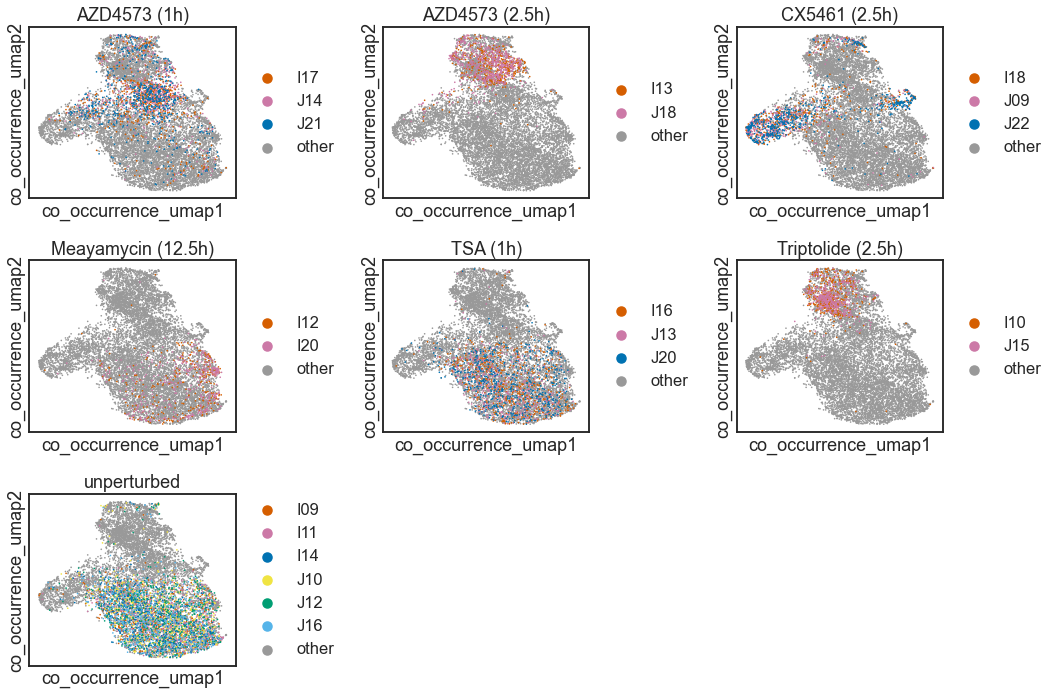

In [10]:
# check if replicate wells are clustering together on umap for each perturbation
perturbations = adata.obs['perturbation_plot'].cat.categories
fig, axes = plt.subplots(3,3, figsize=(15,10))
for p,ax in zip(perturbations, axes.flat):
    tmp = adata.copy()
    tmp.obs[p] = tmp.obs['well_name'].astype('str')
    tmp.obs[p][~(tmp.obs['perturbation_plot'] == p)] = 'other'
    tmp.obs[p] = tmp.obs[p].astype('category')
    tmp.uns[f'{p}_colors'] = ["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73", "#56B4E9"][:len(tmp.obs[p].cat.categories)-1] + ['#999999']
    
    indices = set(range(tmp.shape[0]))
    p_indices = list(np.where(tmp.obs['perturbation_plot'] == p)[0])
    reordered_indices = list(indices.difference(p_indices)) + p_indices

    sc.pl.embedding(tmp[reordered_indices], basis='mpp_umap', color=p, ax=ax, show=False)
    ax.set_title(p)
axes[2,1].axis('off')
axes[2,2].axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'suppl_mpp_umap_wells.png', dpi=300, bbox_inches='tight')


fig, axes = plt.subplots(3,3, figsize=(15,10))
for p,ax in zip(perturbations, axes.flat):
    tmp = adata.copy()
    tmp.obs[p] = tmp.obs['well_name'].astype('str')
    tmp.obs[p][~(tmp.obs['perturbation_plot'] == p)] = 'other'
    tmp.obs[p] = tmp.obs[p].astype('category')
    tmp.uns[f'{p}_colors'] = ["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73", "#56B4E9"][:len(tmp.obs[p].cat.categories)-1] + ['#999999']
    
    indices = set(range(tmp.shape[0]))
    p_indices = list(np.where(tmp.obs['perturbation_plot'] == p)[0])
    reordered_indices = list(indices.difference(p_indices)) + p_indices

    sc.pl.embedding(tmp[reordered_indices], basis='intensity_umap', color=p, ax=ax, show=False)
    ax.set_title(p)
axes[2,1].axis('off')
axes[2,2].axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'suppl_intensity_umap_wells.png', dpi=300, bbox_inches='tight')

fig, axes = plt.subplots(3,3, figsize=(15,10))
for p,ax in zip(perturbations, axes.flat):
    tmp = adata.copy()
    tmp.obs[p] = tmp.obs['well_name'].astype('str')
    tmp.obs[p][~(tmp.obs['perturbation_plot'] == p)] = 'other'
    tmp.obs[p] = tmp.obs[p].astype('category')
    tmp.uns[f'{p}_colors'] = ["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73", "#56B4E9"][:len(tmp.obs[p].cat.categories)-1] + ['#999999']
    
    indices = set(range(tmp.shape[0]))
    p_indices = list(np.where(tmp.obs['perturbation_plot'] == p)[0])
    reordered_indices = list(indices.difference(p_indices)) + p_indices

    sc.pl.embedding(tmp[reordered_indices], basis='co_occurrence_umap', color=p, ax=ax, show=False)
    ax.set_title(p)
axes[2,1].axis('off')
axes[2,2].axis('off')
plt.tight_layout()
plt.savefig(fig_dir/'suppl_co_occ_umap_wells.png', dpi=300, bbox_inches='tight')


## Calculate pairwise similarity between perturbations

### neighborhood enrichment

In [10]:
# calculate neighbohood enrichment
zscore_co_occ, count_co_occ = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                     connectivity_key='co_occurrence', n_perms=1000, 
                                                     numba_parallel=False, copy=True)
zscore_intensity, count_intensity = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                           connectivity_key='intensity', n_perms=1900, 
                                                           numba_parallel=False, copy=True)

100%|██████████| 1900/1900 [00:01<00:00, 1150.29/s]


In [12]:
zscore_mpp, count_mpp = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                               connectivity_key='mpp', n_perms=1900, 
                                               numba_parallel=False, copy=True)

100%|██████████| 1900/1900 [00:01<00:00, 1154.13/s]


### silhouette score

In [24]:
# calculate silhouette score
from sklearn.metrics import silhouette_samples
def bootstrap_silhouette(samples, n=1000, masks=[]):
    res = np.zeros([len(masks), n])
    for i in range(n):
        idx = np.random.choice(np.arange(len(samples)), size=len(samples), replace=True)
        bootstrap_samples = samples[idx]
        for j, mask in enumerate(masks):
            res[j,i] = np.mean(bootstrap_samples[mask[idx]])
    return res

cond_key = 'perturbation_plot'
bootstrap_n = 1000
bootstrap = False

# co-occurrence
if bootstrap:
    siscore_co_occ = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories), bootstrap_n])
else:
    siscore_co_occ = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories)], dtype=object)
# weigh differences in larger intervals higher (proportional to interval size)
distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
distances = np.tile(distances/np.mean(distances), int(len(adata.uns['clusters'])**2)).astype(np.float64)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if i == j:
            siscore_co_occ[i,i] = np.zeros(sum(adata_sub.obs[cond_key]==c1))
        if j <= i:
            continue
        print(i,j,":",c1, c2)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        samples = silhouette_samples(adata_sub.obsm['co_occurrence'], labels=adata_sub.obs[cond_key], metric=cityblock, w=distances)
        if bootstrap:
            res1, res2 = bootstrap_silhouette(samples, n=bootstrap_n, masks=[adata_sub.obs[cond_key]==c1, adata_sub.obs[cond_key]==c2])
        else:
            res1 = samples[adata_sub.obs[cond_key]==c1]
            res2 = samples[adata_sub.obs[cond_key]==c2]
        siscore_co_occ[i,j] = res1
        siscore_co_occ[j,i] = res2
        print(siscore_co_occ[i,j].mean(), siscore_co_occ[j,i].mean())

0 1 : AZD4573 (1h) AZD4573 (2.5h)
0.046788959831511046 0.03267239007945687
0 2 : AZD4573 (1h) CX5461 (2.5h)
0.038010322378405216 0.09910067988447159
0 3 : AZD4573 (1h) Meayamycin (12.5h)
0.07138690149554079 0.0881831485738054
0 4 : AZD4573 (1h) TSA (1h)
0.002171024704857655 0.09391081368108718
0 5 : AZD4573 (1h) Triptolide (2.5h)
0.0038532090567589003 0.09774099992379141
0 6 : AZD4573 (1h) unperturbed
0.019030823051603276 0.07583269339773674
1 2 : AZD4573 (2.5h) CX5461 (2.5h)
0.06353066374605403 0.1331318433688126
1 3 : AZD4573 (2.5h) Meayamycin (12.5h)
0.13298509244162512 0.1598426240064489
1 4 : AZD4573 (2.5h) TSA (1h)
0.07265306830347835 0.16765912804926592
1 5 : AZD4573 (2.5h) Triptolide (2.5h)
-0.02947301253316717 0.08156427840471303
1 6 : AZD4573 (2.5h) unperturbed
0.08910702554961984 0.15209544142172263
2 3 : CX5461 (2.5h) Meayamycin (12.5h)
0.10708043907503677 0.0636343269512316
2 4 : CX5461 (2.5h) TSA (1h)
0.05626160050767865 0.08298957961315678
2 5 : CX5461 (2.5h) Triptolide 

In [36]:
# add diagonal entries
siscore_co_occ[0,0] = np.zeros(len(siscore_co_occ[0,1]))
for i in range(7)[1:]:
    siscore_co_occ[i,i] = np.zeros(len(siscore_co_occ[i,i-1]))

In [43]:
# calculate silhouette score
from sklearn.metrics import silhouette_samples

cond_key = 'perturbation_plot'

# cluster intensity
if bootstrap:
    siscore_intensity = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories), bootstrap_n])
else:
    siscore_intensity = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories)], dtype=object)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if i == j:
            siscore_intensity[i,i] = np.zeros(sum(adata.obs[cond_key]==c1))
        if j <= i:
            continue
        print(i,j,":",c1, c2)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        samples = silhouette_samples(adata_sub.obsm['intensity'], labels=adata_sub.obs[cond_key], metric=cityblock)
        if bootstrap:
            res1, res2 = bootstrap_silhouette(samples, n=bootstrap_n, masks=[adata_sub.obs[cond_key]==c1, adata_sub.obs[cond_key]==c2])
        else:
            res1 = samples[adata_sub.obs[cond_key]==c1]
            res2 = samples[adata_sub.obs[cond_key]==c2]
        siscore_intensity[i,j] = res1
        siscore_intensity[j,i] = res2
        print(siscore_intensity[i,j].mean(), siscore_intensity[j,i].mean())

0 1 : AZD4573 (1h) AZD4573 (2.5h)
0.04902271456553442 0.09156611023371161
0 2 : AZD4573 (1h) CX5461 (2.5h)
0.22326527052247475 0.10005178972407605
0 3 : AZD4573 (1h) Meayamycin (12.5h)
0.22813951843274796 0.18788940952120173
0 4 : AZD4573 (1h) TSA (1h)
0.3036400945102261 0.19733366018142265
0 5 : AZD4573 (1h) Triptolide (2.5h)
0.19178802450637789 0.17943382463976199
0 6 : AZD4573 (1h) unperturbed
0.22342424077672215 0.11042604992537694
1 2 : AZD4573 (2.5h) CX5461 (2.5h)
0.31035710705612846 0.16618747603118567
1 3 : AZD4573 (2.5h) Meayamycin (12.5h)
0.2966061870652298 0.2267992899130248
1 4 : AZD4573 (2.5h) TSA (1h)
0.3892184739354108 0.26679105665587305
1 5 : AZD4573 (2.5h) Triptolide (2.5h)
0.1675861395671474 0.116362132468336
1 6 : AZD4573 (2.5h) unperturbed
0.3168581259523837 0.1838834859871316
2 3 : CX5461 (2.5h) Meayamycin (12.5h)
0.11498678438605417 0.1968215465951191
2 4 : CX5461 (2.5h) TSA (1h)
0.10909651392950707 0.11191689076171783
2 5 : CX5461 (2.5h) Triptolide (2.5h)
0.2205

In [45]:
# calculate silhouette score
from sklearn.metrics import silhouette_samples

cond_key = 'perturbation_plot'

# intensity
if bootstrap:
    siscore_mpp = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories), bootstrap_n])
else:
    siscore_mpp = np.zeros([len(adata.obs[cond_key].cat.categories), len(adata.obs[cond_key].cat.categories)], dtype=object)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if i == j:
            siscore_mpp[i,i] = np.zeros(sum(adata.obs[cond_key]==c1))
        if j <= i:
            continue
        print(i,j,":",c1, c2)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        samples = silhouette_samples(adata_sub.X, labels=adata_sub.obs[cond_key], metric=cityblock)
        if bootstrap:
            res1, res2 = bootstrap_silhouette(samples, n=bootstrap_n, masks=[adata_sub.obs[cond_key]==c1, adata_sub.obs[cond_key]==c2])
        else:
            res1 = samples[adata_sub.obs[cond_key]==c1]
            res2 = samples[adata_sub.obs[cond_key]==c2]
        siscore_mpp[i,j] = res1
        siscore_mpp[j,i] = res2
        print(siscore_mpp[i,j].mean(), siscore_mpp[j,i].mean())

0 1 : AZD4573 (1h) AZD4573 (2.5h)
0.03280065317856695 0.08271846787579967
0 2 : AZD4573 (1h) CX5461 (2.5h)
0.23009441572785133 0.10378119488796592
0 3 : AZD4573 (1h) Meayamycin (12.5h)
0.1845701081156705 0.15393009157641713
0 4 : AZD4573 (1h) TSA (1h)
0.28267499548262687 0.19627848396203168
0 5 : AZD4573 (1h) Triptolide (2.5h)
0.18572218168536428 0.1723417785372982
0 6 : AZD4573 (1h) unperturbed
0.20905453360258267 0.09444862277257589
1 2 : AZD4573 (2.5h) CX5461 (2.5h)
0.31764509805783553 0.1672771806615107
1 3 : AZD4573 (2.5h) Meayamycin (12.5h)
0.24983224534748424 0.18123943929274192
1 4 : AZD4573 (2.5h) TSA (1h)
0.36886640075410926 0.2587175501908561
1 5 : AZD4573 (2.5h) Triptolide (2.5h)
0.18473507227251984 0.12867220210821254
1 6 : AZD4573 (2.5h) unperturbed
0.3005483517482428 0.15956061547062836
2 3 : CX5461 (2.5h) Meayamycin (12.5h)
0.0891878408945443 0.19129310370867206
2 4 : CX5461 (2.5h) TSA (1h)
0.07934098830056327 0.11631506016616526
2 5 : CX5461 (2.5h) Triptolide (2.5h)
0.

In [52]:
# add diagonal entries
siscore_intensity[0,0] = np.zeros(len(siscore_intensity[0,1]))
for i in range(7)[1:]:
    siscore_intensity[i,i] = np.zeros(len(siscore_intensity[i,i-1]))

In [53]:
# save siscores
pickle.dump([siscore_mpp, siscore_intensity, siscore_co_occ], open(fig_dir/'siscores_all.pickle', 'wb'))

# export si scores as csv for Scott
#pd.DataFrame(siscore_mpp).to_csv('fig4/siscore_mpp.csv')
#pd.DataFrame(siscore_intensity).to_csv('fig4/siscore_intensity.csv')
#pd.DataFrame(siscore_co_occ).to_csv('fig4/siscore_co_occ.csv')


In [18]:
cond_key = 'perturbation_plot'

# classification from MPP
acc_mpp = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.X)
        acc_mpp[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_mpp[j,i] = acc_mpp[i,j]
        
# classification from co-occ
acc_co_occ = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.obsm['co_occurrence'])
        acc_co_occ[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_co_occ[j,i] = acc_co_occ[i,j]

# classification from intensity
acc_intensity = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.obsm['intensity'])
        acc_intensity[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_intensity[j,i] = acc_intensity[i,j]

0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


## Plot pairwise similarities

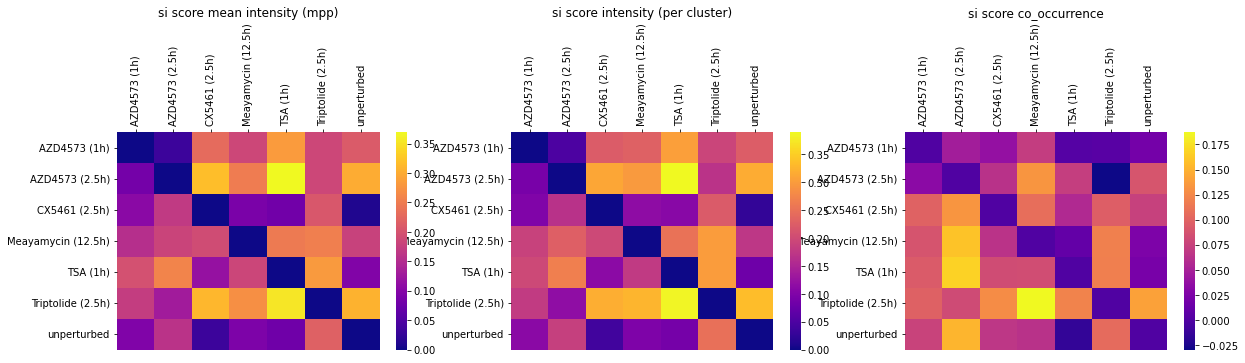

In [63]:
# plot silhouette scores
fig, axes = plt.subplots(1,3, figsize=(20,4))

sns.heatmap(siscore_mpp.mean(axis=-1), vmin=None, vmax=None, cmap='plasma', ax=axes[0])
axes[0].set_title('si score mean intensity (mpp)')

sns.heatmap(siscore_intensity.mean(axis=-1), vmin=None, vmax=None, cmap='plasma', ax=axes[1])
axes[1].set_title('si score intensity (per cluster)')

sns.heatmap(siscore_co_occ.mean(axis=-1), vmin=None, vmax=None, cmap='plasma', ax=axes[2])
axes[2].set_title('si score co_occurrence')

for ax in axes.flat:
    ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
    ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
    ax.xaxis.set_ticks_position('top')

### plot silhouette scores for figure

In [9]:
# load saved si scores
# siscores.pickle contains bootstrapped means
# siscores_all.pickle contains all raw siscores
siscore_mpp, siscore_intensity, siscore_co_occ = pickle.load(open(fig_dir/'siscores_all.pickle', 'rb'))

In [10]:
from scipy.cluster.hierarchy import linkage, leaves_list
# calculate linkage
link = linkage(np.vectorize(np.mean)(siscore_mpp))
idx_order = leaves_list(link)

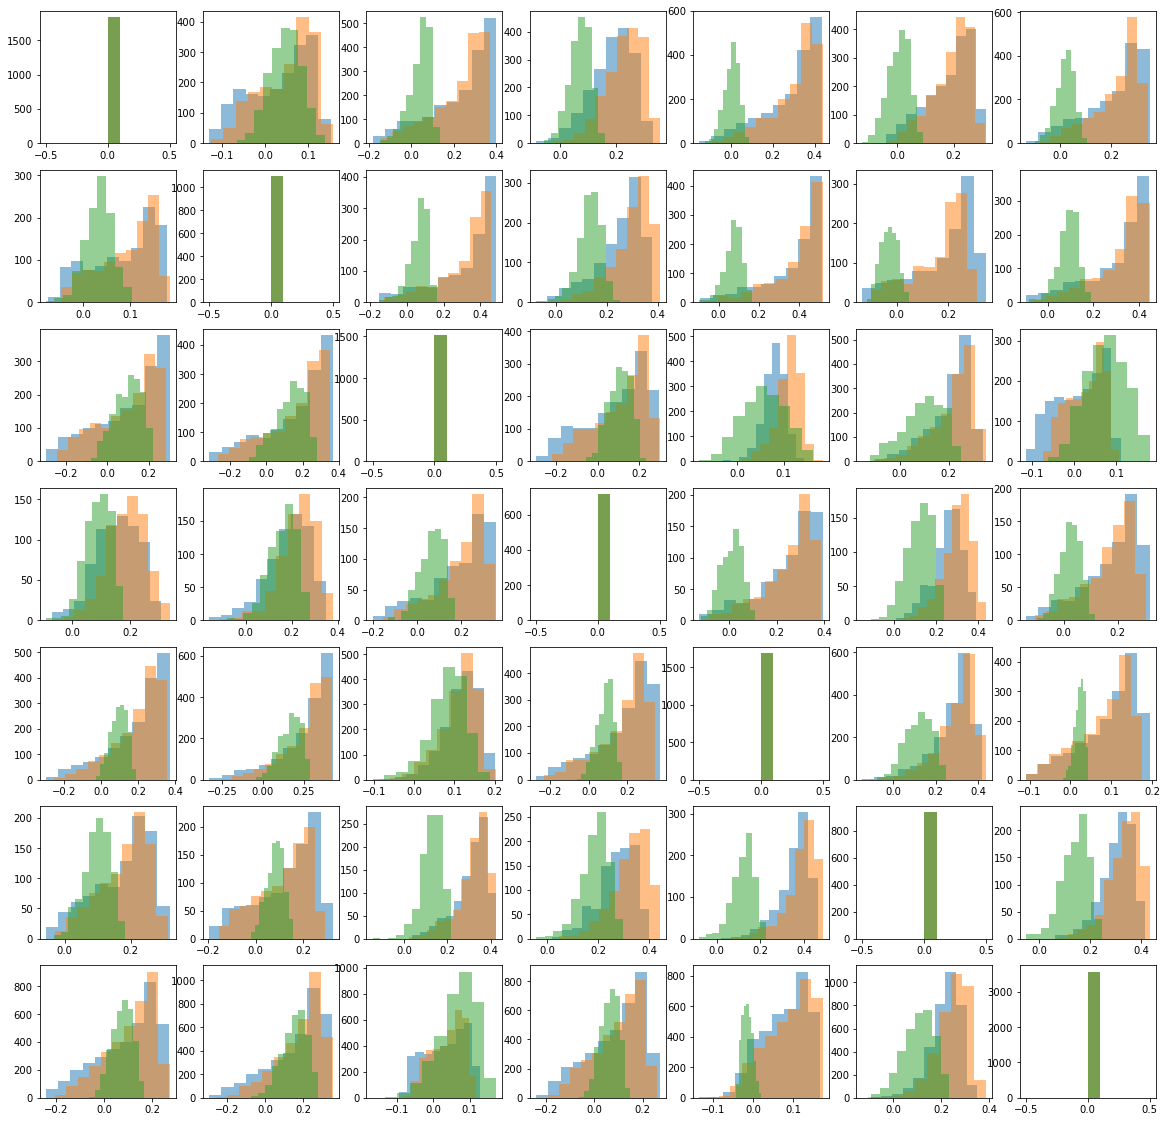

In [80]:
# distribution of scores
fig, axes = plt.subplots(7,7, figsize=(20,20))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.hist(siscore_mpp[i,j], alpha=0.5)
        ax.hist(siscore_intensity[i,j], alpha=0.5)
        ax.hist(siscore_co_occ[i,j], alpha=0.5)

In [11]:
from scipy.stats import wilcoxon 
# stats: paired sample tests, do not assume normality -- wilcoxon signed rank test

In [15]:
# functions for dotplots
def get_pvals(scores1, scores2):
    pvals = np.zeros((7,7))
    for i in range(7):
        for j in range(7):
            if i == j:
                continue
            pvals[i,j] = wilcoxon(scores1[i,j], scores2[i,j])[1]
    # adjust for multiple testing
    pvals = pvals*7*7
    pvals_sizes = np.zeros((7,7), dtype=object)
    pvals_sizes[:,:] = 'p > 0.05'
    pvals_sizes[pvals < 0.05] = 'p < 0.05'
    pvals_sizes[pvals < 0.001] = 'p < 0.001'
    return pvals_sizes

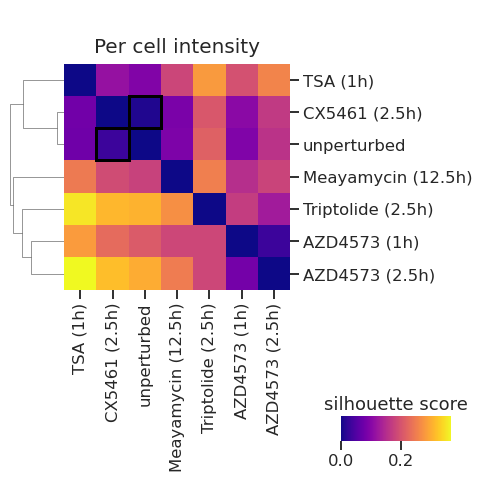

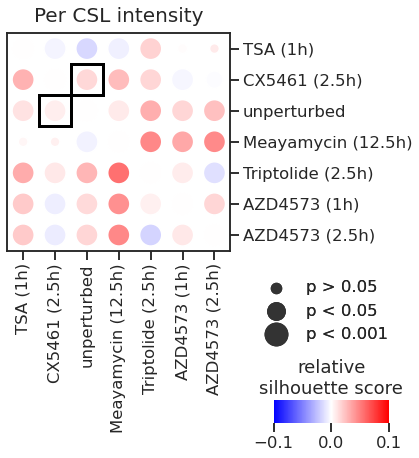

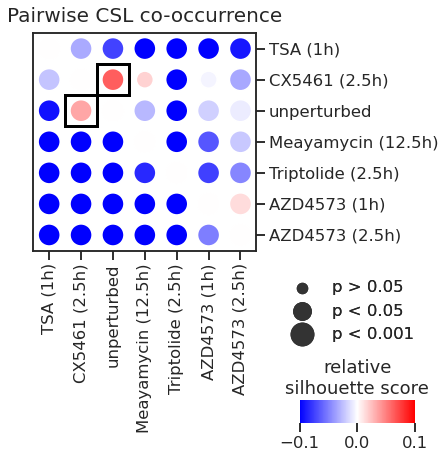

In [19]:
sns.set_style('ticks')
sns.set_context('talk')
xx, yy = np.meshgrid(range(7), range(7))


# --- intensity
g = sns.clustermap(np.vectorize(np.mean)(siscore_mpp)[:,idx_order], vmin=None, vmax=None, cmap='plasma', yticklabels=adata.obs['perturbation_plot'].cat.categories,
              xticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order], figsize=(7,7), cbar_pos=(0.7, 0.1, 0.22, 0.05),  row_linkage=link, col_cluster=False,
                  cbar_kws={'orientation':'horizontal'})
g.ax_cbar.set_title('silhouette score')
# highlight coord
for coord in ([1,2],[2,1]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.ax_heatmap.add_patch(rect)
plt.text(0.5,1.05, 'Per cell intensity', transform=g.ax_heatmap.transAxes, fontdict={'size': 20}, ha='center')
plt.savefig(fig_dir/'intensity_siscore.png', dpi=300)

# --- cluster intensity - intensity
hue = (np.vectorize(np.mean)(siscore_intensity) - np.vectorize(np.mean)(siscore_mpp))
pvals = get_pvals(siscore_mpp, siscore_intensity)                            
fig, ax = plt.subplots(1,1, figsize=(4,4))
g = sns.scatterplot(x=xx.flatten(), y=yy.flatten(), hue=hue[idx_order][:,idx_order].flatten(), size=pvals[idx_order][:,idx_order].flatten(), 
                    sizes={'p > 0.05': 100, 'p < 0.05': 300, 'p < 0.001': 500}, 
                    hue_norm = (-0.1,0.1), palette='bwr',
                   )
# adjust axes
g.set_yticks(range(7))
g.set_yticklabels(adata.obs['perturbation_plot'].cat.categories[idx_order])
g.set_xticks(range(7))
g.set_xticklabels(adata.obs['perturbation_plot'].cat.categories[idx_order], rotation=90)
g.yaxis.tick_right()
g.set_ylim((-0.5, 6.5))
g.set_xlim((-0.5, 6.5))
g.invert_yaxis()

# highlight coord
for coord in ([0.5,1.5],[1.5,0.5]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.add_patch(rect)
plt.text(0.5,1.05, 'Per CSL intensity', transform=g.transAxes, fontdict={'size': 20}, ha='center')

# pvals legend
handles, labels = ax.get_legend_handles_labels()
l = plt.legend([handles[6], handles[7], handles[5]], [labels[6], labels[7], labels[5]], bbox_to_anchor=(1.1, -0.45), loc=(1,1), frameon=False)
g.add_artist(l)

# colorbar legend
norm = plt.Normalize(-0.1, 0.1)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.15, ax.get_position().y0-0.6, 0.4, 0.08])
cb = ax.figure.colorbar(sm, cax=cax, orientation='horizontal')
cb.outline.set_visible(False)
cax.set_title('relative\nsilhouette score')

# save
plt.savefig(fig_dir/'cluster_intensity_siscore_difference.png', bbox_inches='tight', dpi=300)


# --- co occ - intensity
hue = (np.vectorize(np.mean)(siscore_co_occ) - np.vectorize(np.mean)(siscore_mpp))
pvals = get_pvals(siscore_mpp, siscore_co_occ)                            
fig, ax = plt.subplots(1,1, figsize=(4,4))
g = sns.scatterplot(x=xx.flatten(), y=yy.flatten(), hue=hue[idx_order][:,idx_order].flatten(), size=pvals[idx_order][:,idx_order].flatten(), 
                    sizes={'p > 0.05': 100, 'p < 0.05': 300, 'p < 0.001': 500}, 
                    hue_norm = (-0.1,0.1), palette='bwr',
                   )
# adjust axes
g.set_yticks(range(7))
g.set_yticklabels(adata.obs['perturbation_plot'].cat.categories[idx_order])
g.set_xticks(range(7))
g.set_xticklabels(adata.obs['perturbation_plot'].cat.categories[idx_order], rotation=90)
g.yaxis.tick_right()
g.set_ylim((-0.5, 6.5))
g.set_xlim((-0.5, 6.5))
g.invert_yaxis()

# highlight coord
for coord in ([0.5,1.5],[1.5,0.5]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.add_patch(rect)
plt.text(0.5,1.05, 'Pairwise CSL co-occurrence', transform=g.transAxes, fontdict={'size': 20}, ha='center')

# pvals legend
#handles, labels = ax.get_legend_handles_labels()  # use handles from plot before
l = plt.legend([handles[6], handles[7], handles[5]], [labels[6], labels[7], labels[5]], bbox_to_anchor=(1.1, -0.45), loc=(1,1), frameon=False)
g.add_artist(l)

# colorbar legend
norm = plt.Normalize(-0.1, 0.1)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.15, ax.get_position().y0-0.6, 0.4, 0.08])
cb = ax.figure.colorbar(sm, cax=cax, orientation='horizontal')
cb.outline.set_visible(False)
cax.set_title('relative\nsilhouette score')

# save
plt.savefig(fig_dir/'co_occ_siscore_difference.png', bbox_inches='tight', dpi=300) 

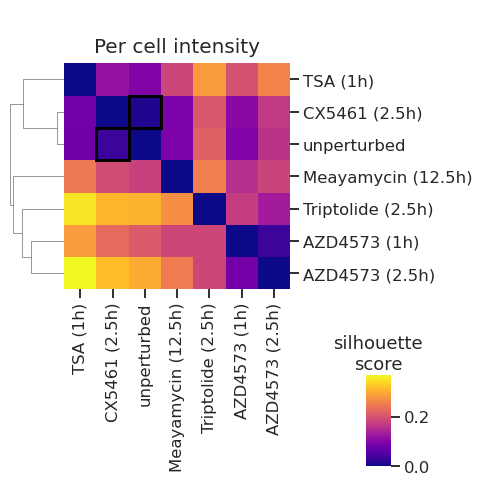

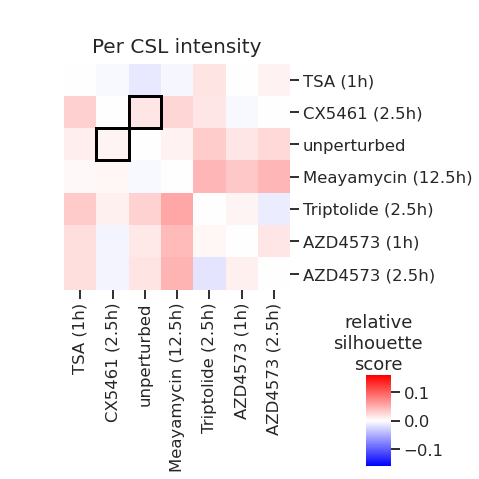

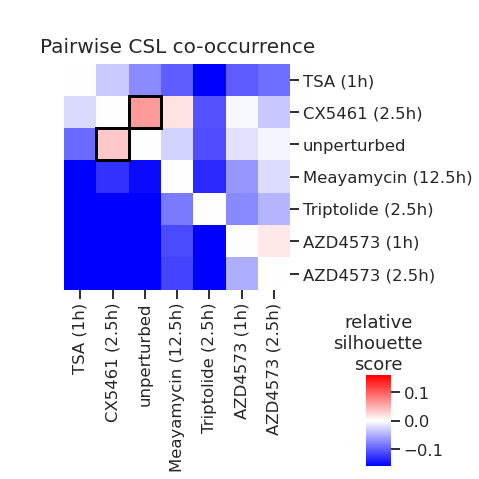

In [94]:
# plot si scores -- OLD, no pvals
sns.set_style('ticks')
sns.set_context('talk')
# intensity
g = sns.clustermap(siscore_mpp.mean(axis=-1)[:,idx_order], vmin=None, vmax=None, cmap='plasma', yticklabels=adata.obs['perturbation_plot'].cat.categories,
              xticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order], figsize=(7,7), cbar_pos=(0.75, 0.05, 0.05, 0.18),  row_linkage=link, col_cluster=False)
g.ax_cbar.set_title('silhouette\nscore')
# highlight coord
for coord in ([1,2],[2,1]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.ax_heatmap.add_patch(rect)
plt.text(0.5,1.05, 'Per cell intensity', transform=g.ax_heatmap.transAxes, fontdict={'size': 20}, ha='center')
plt.savefig(fig_dir/'intensity_siscore.png')

# cluster intensity - intensity 
#plt.figure()
g = sns.clustermap((siscore_intensity - siscore_mpp).mean(axis=-1)[idx_order][:,idx_order], vmin=-0.16, vmax=0.16, cmap='bwr', 
    xticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order], yticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order],
    cbar_pos=(0.75, 0.05, 0.05, 0.18), row_cluster=False, col_cluster=False, figsize=(7,7))
g.ax_cbar.set_title('relative\nsilhouette\nscore')
# highlight coord
for coord in ([1,2],[2,1]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.ax_heatmap.add_patch(rect)
plt.text(0.5,1.05, 'Per CSL intensity', transform=g.ax_heatmap.transAxes, fontdict={'size': 20}, ha='center')
plt.savefig(fig_dir/'cluster_intensity_siscore_difference.png')

# co occurrence - intensity 
#plt.figure()
g = sns.clustermap((siscore_co_occ - siscore_mpp).mean(axis=-1)[idx_order][:,idx_order], vmin=-0.16, vmax=0.16, cmap='bwr', 
    xticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order], yticklabels=adata.obs['perturbation_plot'].cat.categories[idx_order],
    cbar_pos=(0.75, 0.05, 0.05, 0.18), row_cluster=False, col_cluster=False, figsize=(7,7))
g.ax_cbar.set_title('relative\nsilhouette\nscore')
# highlight coord
for coord in ([1,2],[2,1]):
    rect = plt.Rectangle(coord, 1,1, color="black", linewidth=3, fill=False, clip_on=False)
    g.ax_heatmap.add_patch(rect)
plt.text(0.5,1.05, 'Pairwise CSL co-occurrence', transform=g.ax_heatmap.transAxes, fontdict={'size': 20}, ha='center')
plt.savefig(fig_dir/'co_occ_siscore_difference.png') 




### barplot comparing selected siscores
from unperturbed to CX and to TSA

In [24]:
perturbations = list(adata.obs['perturbation_plot'].cat.categories)
idx_unp = perturbations.index('unperturbed')
idx_cx = perturbations.index('CX5461 (2.5h)')
idx_tsa = perturbations.index('TSA (1h)')

In [71]:
df1 = pd.DataFrame({'Per cell intensity': siscore_mpp[idx_unp, idx_cx], 'Per CSL intensity': siscore_intensity[idx_unp, idx_cx], 
                   'Pairwise CSL co-occurrence': siscore_co_occ[idx_unp, idx_cx], 'pert': 'CX5461\n(2.5h)'})
df2 = pd.DataFrame({'Per cell intensity': siscore_mpp[idx_unp, idx_tsa], 'Per CSL intensity': siscore_intensity[idx_unp, idx_tsa], 
                   'Pairwise CSL co-occurrence': siscore_co_occ[idx_unp, idx_tsa], 'pert': 'TSA\n(1h)'})
df = pd.concat([df1, df2])
df = pd.melt(df, id_vars='pert')

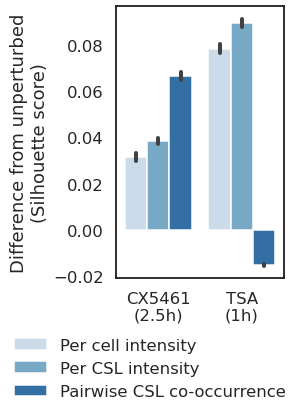

In [76]:
fig, axes = plt.subplots(1,1, figsize=(3,5))
g = sns.barplot(data=df, y='value', x='pert', hue='variable', ci=95, palette='Blues')
g.legend_.set_title(None)
g.set_ylabel('Difference from unperturbed\n(Silhouette score)')
g.set_xlabel(None)
sns.move_legend(
    g, 'lower center',
    bbox_to_anchor=(0.2, -0.5), ncol=1, title=None, frameon=False,
)
plt.savefig(fig_dir/'silhouette_barplot_CX5461_TSA.png', bbox_inches='tight', dpi=300)

### other plots (OLD)

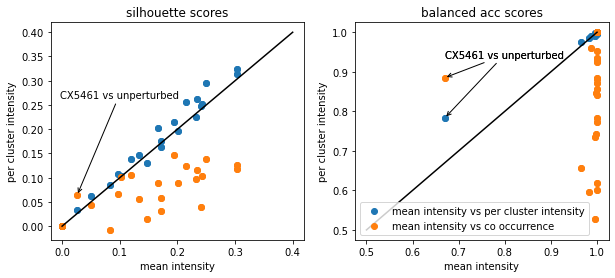

In [142]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].scatter(siscore_mpp.flat, siscore_intensity.flat, label='mean intensity vs per cluster intensity')
axes[0].scatter(siscore_mpp.flat, siscore_co_occ.flat, label='mean intensity vs co occurrence')
axes[0].plot([0,0.4],[0,0.4], c='black')
axes[0].set_xlabel('mean intensity')
axes[0].set_ylabel('per cluster intensity')
axes[0].set_title('silhouette scores')

coord = np.array([siscore_mpp[2,6], siscore_co_occ[2,6]])
axes[0].annotate(text='CX5461 vs unperturbed',
            xy=coord,
            xycoords='data',
            fontsize=10,
            xytext=coord+[-0.03,0.2],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))   # New param


axes[1].scatter(acc_mpp.flat, acc_intensity.flat, label='mean intensity vs per cluster intensity')
axes[1].scatter(acc_mpp.flat, acc_co_occ.flat, label='mean intensity vs co occurrence')
axes[1].plot([0.5,1],[0.5,1], c='black')
axes[1].set_xlabel('mean intensity')
axes[1].set_ylabel('per cluster intensity')
axes[1].set_title('balanced acc scores')

coord = np.array([acc_mpp[2,6], acc_co_occ[2,6]])
axes[1].annotate(text='CX5461 vs unperturbed',
            xy=coord,
            xycoords='data',
            fontsize=10,
            xytext=coord+[0.0,0.05],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))
coord1 = np.array([acc_mpp[2,6], acc_intensity[2,6]])
axes[1].annotate(text='CX5461 vs unperturbed',
            xy=coord1,
            xycoords='data',
            fontsize=10,
            xytext=coord+[0.0,0.05],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.legend()

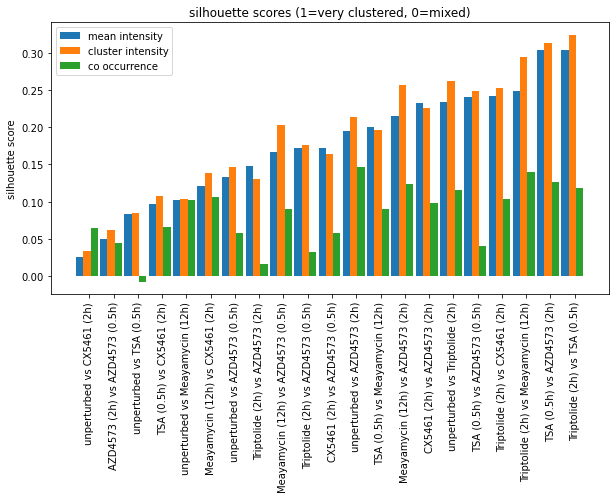

In [146]:
labels = []
sel_mpp = []
sel_intensity = []
sel_co_occ = [] 
for i in range(len(siscore_mpp)):
    for j in range(len(siscore_mpp)):
        if j >= i:
            continue
        labels.append('{} vs {}'.format(adata.obs['perturbation_plot'].cat.categories[i], adata.obs['perturbation_plot'].cat.categories[j])) 
        sel_mpp.append(siscore_mpp[i,j])
        sel_intensity.append(siscore_intensity[i,j])
        sel_co_occ.append(siscore_co_occ[i,j])
# sort lists by mpp scores
sel_intensity = [x for _,x in sorted(zip(sel_mpp, sel_intensity))]
sel_co_occ = [x for _,x in sorted(zip(sel_mpp, sel_co_occ))]
labels = [x for _,x in sorted(zip(sel_mpp, labels))]
sel_mpp = sorted(sel_mpp)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(x=np.array(range(len(labels)))+0.1, height=sel_mpp, width=0.3, label='mean intensity')
ax.bar(x=np.array(range(len(labels)))+0.4, height=sel_intensity, width=0.3, label='cluster intensity')
ax.bar(x=np.array(range(len(labels)))+0.7, height=sel_co_occ, width=0.3, label='co occurrence')

ax.set_ylabel('silhouette score')
ax.set_xticks(np.array(range(len(labels)))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('silhouette scores (1=very clustered, 0=mixed)')
plt.legend()

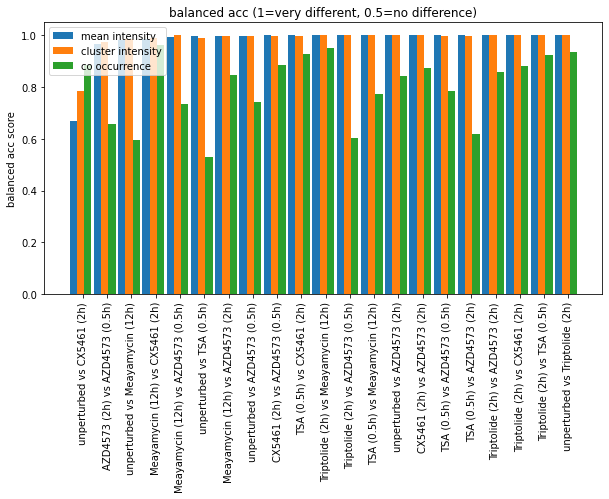

In [148]:
labels = []
sel_mpp = []
sel_intensity = []
sel_co_occ = [] 
for i in range(len(acc_mpp)):
    for j in range(len(acc_mpp)):
        if j >= i:
            continue
        labels.append('{} vs {}'.format(adata.obs['perturbation_plot'].cat.categories[i], adata.obs['perturbation_plot'].cat.categories[j])) 
        sel_mpp.append(acc_mpp[i,j])
        sel_intensity.append(acc_intensity[i,j])
        sel_co_occ.append(acc_co_occ[i,j])
# sort lists by mpp scores
sel_intensity = [x for _,x in sorted(zip(sel_mpp, sel_intensity))]
sel_co_occ = [x for _,x in sorted(zip(sel_mpp, sel_co_occ))]
labels = [x for _,x in sorted(zip(sel_mpp, labels))]
sel_mpp = sorted(sel_mpp)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(x=np.array(range(len(labels)))+0.1, height=sel_mpp, width=0.3, label='mean intensity')
ax.bar(x=np.array(range(len(labels)))+0.4, height=sel_intensity, width=0.3, label='cluster intensity')
ax.bar(x=np.array(range(len(labels)))+0.7, height=sel_co_occ, width=0.3, label='co occurrence')

ax.set_ylabel('balanced acc score')
ax.set_xticks(np.array(range(len(labels)))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('balanced acc (1=very different, 0.5=no difference)')
plt.legend()

## Plot several UMAPs for intensity + mpp to look ad AZD differences
Why is AZD separated in intensity umap? Scott says only small differences in dotplots. 

Is it due to random chance? ->Change UMAP seeds

Result: No, same pattern, even when re-running UMAP with different seeds

In [ ]:
adata = ad.read('fig4/cell_adata.h5ad')

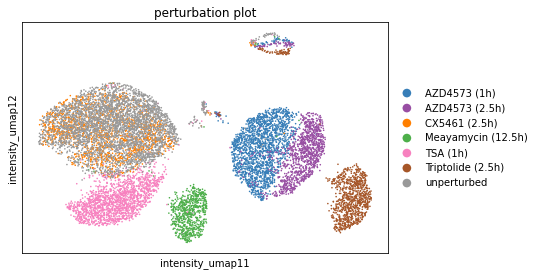

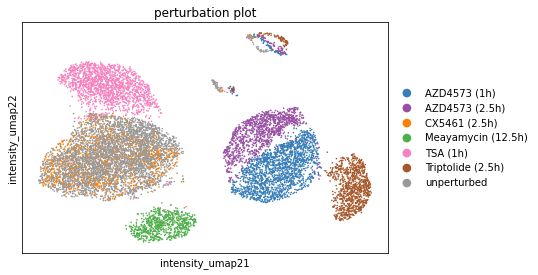

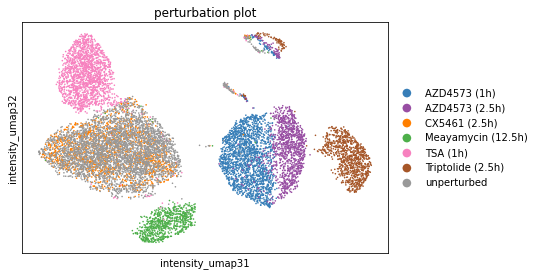

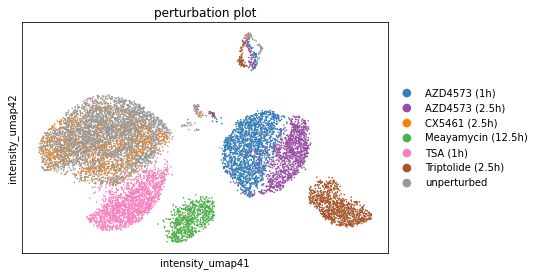

In [10]:
# calculate and plot several UMAPS
for s in [1,2,3,4]:
    adata.obsm[f'X_intensity_umap{s}'] = sc.tl.umap(adata, neighbors_key='intensity', copy=True, random_state=s).obsm['X_umap']
    sc.pl.scatter(adata, basis=f'intensity_umap{s}', color='perturbation_plot')

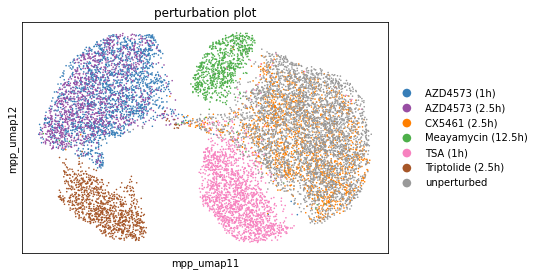

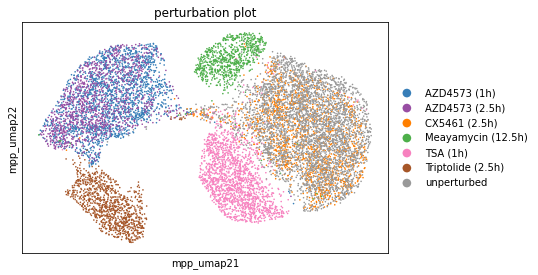

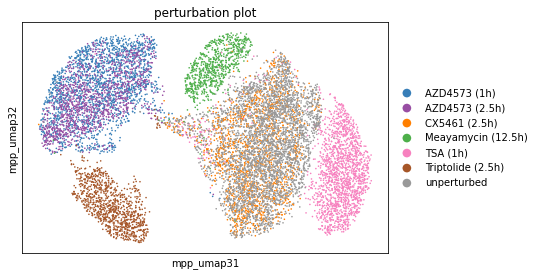

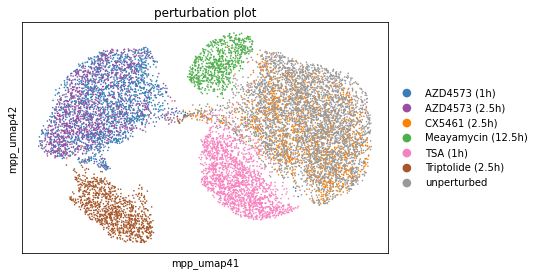

In [11]:
# calculate and plot several UMAPS
for s in [1,2,3,4]:
    adata.obsm[f'X_mpp_umap{s}'] = sc.tl.umap(adata, neighbors_key='mpp', copy=True, random_state=s).obsm['X_umap']
    sc.pl.scatter(adata, basis=f'mpp_umap{s}', color='perturbation_plot')